In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

## Load Data

In [3]:
data_path = os.path.join(os.getcwd(), 'data/fold/Foldchanges_cb_all.txt')
data_df = pd.read_csv(data_path, delimiter='\t')
data_df.head()

,Motif,Kplus37_Kminus37,Cplus37_Kplus37,CKplus37_Kplus37,Cmutplus37_Kplus37,Uplus37_Kplus37,Cplus37_CKplus37,Cplus37_Cmutplus37,Cplus37_Uplus37,CKplus37_Cmutplus37,...,Cplus30_Uplus30,CKplus30_Cmutplus30,CKplus30_Uplus30,Cmutplus30_Uplus30,Kplus37_Kplus30,Kminus37_Kminus30,Cplus37_Cplus30,CKplus37_CKplus30,Cmutplus37_Cmutplus30,Uplus37_Uplus30
0,AAAAAAAA,0.096300,0.065529,-0.595860,-0.732426,-0.999574,0.661389,0.797955,1.065103,0.136567,...,0.118410,-0.083936,-0.384684,-0.300749,1.153103,0.313703,1.204599,1.046304,0.825802,0.257906
1,AAAAAAAC,-3.065422,-0.395462,-1.048439,-0.795461,0.032576,0.652974,0.399997,-0.428039,-0.252980,...,-0.631606,1.076100,0.138822,-0.937279,0.418115,0.534812,-0.286364,-1.709768,-0.380691,-0.489931
2,AAAAAAAG,-0.393651,-0.057606,-0.648082,-0.707792,-1.005540,0.590476,0.650185,0.947933,0.059709,...,0.521351,-0.064781,0.223867,0.288648,-0.128351,-0.680444,0.043262,-0.249730,-0.374221,-0.383320
3,AAAAAAAT,-0.006330,-0.314588,-0.286443,-0.152884,0.561877,-0.028146,-0.161705,-0.876465,-0.133559,...,0.229000,0.360185,0.063500,-0.296685,-0.573670,-0.449645,-1.065893,-0.872248,-0.378504,0.039572
4,AAAAAACA,0.382334,-0.075749,-0.011558,0.148627,-0.986944,-0.064191,-0.224375,0.911194,-0.160184,...,1.406119,-0.273435,0.646064,0.919499,-0.394397,0.277991,-0.874104,-0.049859,-0.163110,-0.379181


## Split Train & Test Sets

In [4]:
random_seed = 444

In [5]:
def split_train_test(data_df, random_seed, test_ratio=0.2):
    rs = np.random.RandomState(random_seed)
    
    n = len(data_df)
    indices = list(range(n))
    
    test_idx = rs.choice(indices, int(test_ratio * n), replace=False)
    test_idx_set = set(test_idx.tolist())
    train_idx = np.array([idx for idx in indices if idx not in test_idx_set])
    
    train_df = data_df.iloc[train_idx].reset_index(drop=True)
    test_df = data_df.iloc[test_idx].reset_index(drop=True)
    
    return train_df, test_df, train_idx, test_idx

In [6]:
train_df, test_df, train_idx, test_idx = split_train_test(data_df, random_seed=random_seed, test_ratio=0.2)

In [7]:
len(train_df), len(test_df)

(52429, 13107)

## Distribution of differential expression responses

In [8]:
output_columns = data_df.columns.tolist()[1:]

print('Number of outputs:', len(output_columns))

Number of outputs: 28


In [24]:
def plot_distributions(data, output_columns):
    n_cols = 4
    n_rows = int(np.ceil(len(output_columns) / n_cols))
    f, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    palette = sns.color_palette()
    
    plt.rcParams['patch.linewidth'] = 0
    plt.rcParams['patch.edgecolor'] = 'none'
    
    for i, output_column in enumerate(output_columns):
        ax = axes[i]
        if isinstance(data, np.ndarray):
            y = data[:, i]
        else:
            y = data[output_column].values
            
        mean = np.mean(y)
        ax.hist(y, bins=80)
        ax.axvline(mean, color=palette[1], label=f'{mean:.2f}')
        ax.set_title(f'#{i + 1} {output_column}')
        ax.legend()

**Comments**: All but 2 outputs (#1 and #12) are unimodal and normally distributed. #1 and #12 appear to be bi-modal.

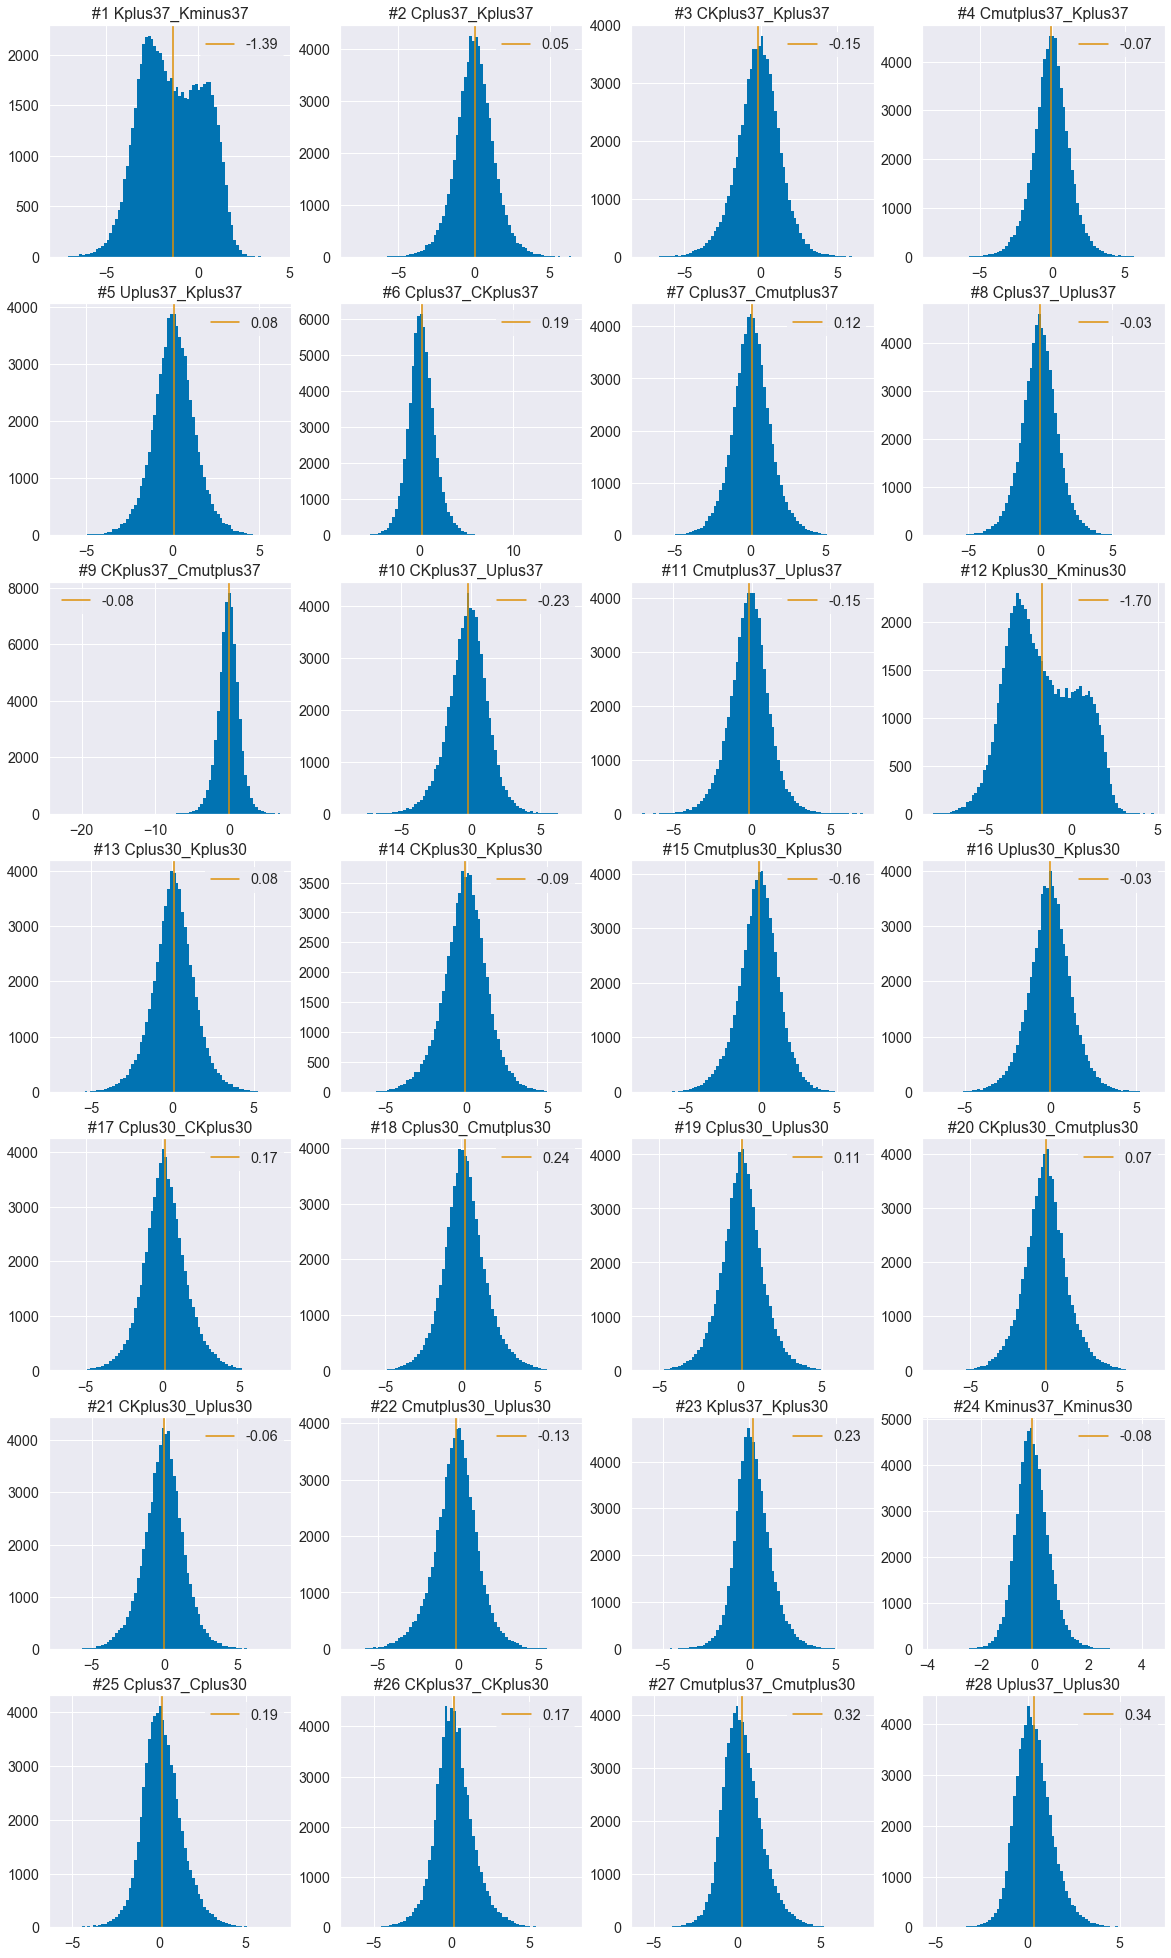

In [25]:
plot_distributions(data_df, output_columns)

## Prepare dataset

Each motif letter is one-hot encoded - i.e. represented as a binary vector of 4 elements - resulting in 8 * 4 = 32 input features.

In [11]:
def get_one_hot_encoding(motifs):
    output = []
    for motif in motifs:
        row = []
        for l in motif:
            if l == 'A':
                row += [1, 0, 0, 0]
            elif l == 'T':
                row += [0, 1, 0, 0]
            elif l == 'G':
                row += [0, 0, 1, 0]
            elif l == 'C':
                row += [0, 0, 0, 1]
            else:
                raise ValueError(f'Unknown letter: {l}')
        
        output.append(row)
        
    return np.array(output, dtype=np.float64)

In [12]:
def normalize(y, mean, std):
    return (y - mean) / std

def denormalize(y_norm, mean, std):
    return (y_norm * std) + mean

In [13]:
y = data_df[output_columns].values.astype(np.float64)
means = np.mean(y, axis=0)
stds = np.std(y, axis=0)

x_train = get_one_hot_encoding(train_df['Motif'].values)
x_test = get_one_hot_encoding(test_df['Motif'].values)

y_train = train_df[output_columns].values.astype(np.float64)
y_train_norm = normalize(y_train, means, stds)

y_test = test_df[output_columns].values.astype(np.float64)
y_test_norm = normalize(y_test, means, stds)

print(f'Train set shape: x = {x_train.shape}, y = {y_train.shape}')
print(f'Test set shape:  x = {x_test.shape}, y = {y_test.shape}')

Train set shape: x = (52429, 32), y = (52429, 28)
Test set shape:  x = (13107, 32), y = (13107, 28)


## Modeling

The following model is composed of 28 independent normal distributions (on per differential expression responses) whose means and standard deviations are modeled using a typical feed forward neural network.

This architecture should have no issue fitting the normal unimodal and bi-modal distributions of differential expression responses plotted above.

In [14]:
def regression_model(n_inputs, n_outputs, dropout=0.5, l2_reg=0.):
    keras.backend.set_floatx('float64')
    
    inputs = keras.Input(shape=(n_inputs,), name='motif')
    
    x = keras.layers.Dense(128, activation='relu')(inputs)
    x = keras.layers.Dropout(dropout)(x)
    
    means = []
    stds = []
    for i in range(n_outputs):
        xi = keras.layers.Dense(32, activation='relu')(x)
        xi = keras.layers.Dropout(dropout)(xi)
        
        logits_i = keras.layers.Dense(
            units=2,
            kernel_regularizer=keras.regularizers.l2(l=l2_reg),
        )(xi)
        
        means.append(logits_i[:,:1])
        stds.append(logits_i[:,1:])
        
    logits = keras.layers.concatenate(means + stds, axis=1)
    
    outputs = tfp.layers.IndependentNormal(n_outputs)(logits)
    
    return keras.Model(inputs=inputs, outputs=outputs)


def compile_model(model, learning_rate, metrics=None):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True),
        loss=lambda y, normal_dist: -normal_dist.log_prob(y),
        metrics=metrics,
    )

In [40]:
learning_rate = 1e-4
n_inputs = x_train.shape[1]
n_outputs = y_train.shape[1]

model = regression_model(n_inputs, n_outputs)
compile_model(model, learning_rate=learning_rate, metrics=['mae'])

In [41]:
%%time
do_train = False
batch_size = 32
n_epochs = 50
model_path = os.path.join(os.getcwd(), 'saved_models_fold/model.h5')

if do_train:
    model.fit(
        x_train,
        y_train_norm,
        validation_data=(x_test, y_test_norm),
        batch_size=batch_size,
        epochs=n_epochs,
    )
    model.save(model_path)
else:
    model.load_weights(model_path)

model.evaluate(x_test, y_test_norm, verbose=0)

CPU times: user 2.78 s, sys: 306 ms, total: 3.08 s
Wall time: 2 s


[36.986424605815664, 1.0580099457065477]

## Results analysis

In [17]:
y_hat = model(x_test)
y_mean = denormalize(y_hat.mean().numpy(), means, stds)
y_std = denormalize(y_hat.stddev().numpy(), means, stds)
print(f'Output shape: {y_mean.shape}')

Output shape: (13107, 28)


### Distributions

In [34]:
def plot_distributions_true_vs_pred(y_true, y_pred, output_columns):
    n_cols = 4
    n_rows = int(np.ceil(len(output_columns) / n_cols))
    f, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    palette = sns.color_palette()
    
    plt.rcParams['patch.linewidth'] = 0
    plt.rcParams['patch.edgecolor'] = 'none'
    
    for i, output_column in enumerate(output_columns):
        ax = axes[i]
        
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
            
        mean_t = np.mean(y_t)
        mean_p = np.mean(y_p)
        
        bins_p = 40
        if np.std(y_p) < 0.3:
            bins_p = 5
        
        label_t = None
        label_p = None
        if i == 0:
            label_t = 'actual'
            label_p = 'prediction'

        ax.hist(y_t, color=palette[0], alpha=0.6, bins=50, label=label_t)        
        ax.hist(y_p, color=palette[1], alpha=0.6, bins=bins_p, label=label_p)
        
        ax.set_title(f'#{i + 1} {output_column}')
        
        if i == 0:
            ax.legend()

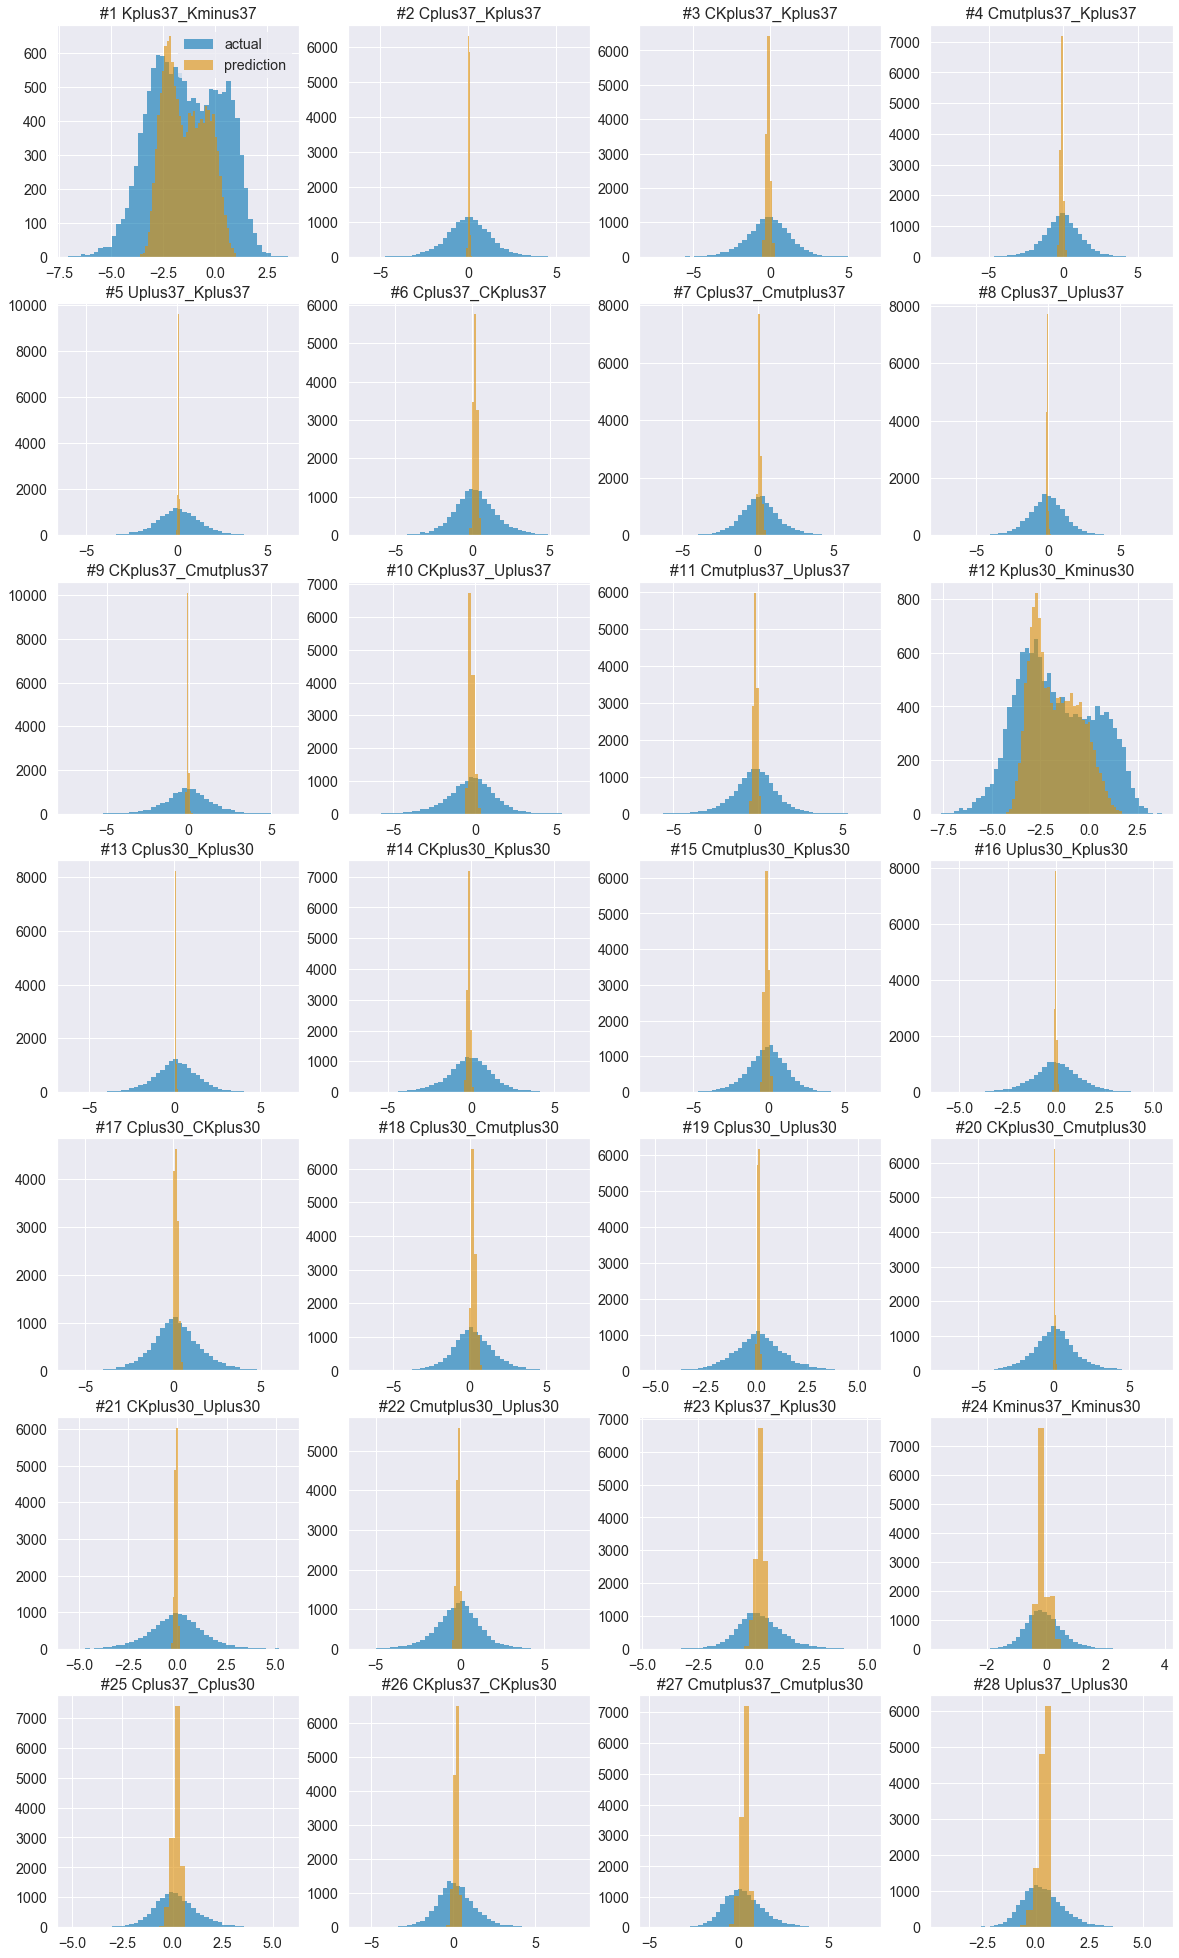

In [35]:
plot_distributions_true_vs_pred(y_test, y_mean, output_columns)

### Metrics (MAE, RMSE, Correlation)

Sorted by correlation (best first)

In [30]:
def compute_metrics(y_true, y_pred, output_columns):
    maes = np.mean(np.abs(y_true - y_pred), axis=0)
    rmses = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    
    output = []
    for i, col in enumerate(output_columns):
        mae = maes[i]
        rmse = rmses[i]
        corr = np.corrcoef(y_true[:,i], y_pred[:,i])[0, 1]
        
        output.append([
            i + 1,
            col,
            mae,
            rmse,
            corr
        ])
        
    df = pd.DataFrame(output, columns=['#', 'Output', 'MAE', 'RMSE', 'Correlation'])
    df = df.set_index('#', drop=True)
    return df

In [31]:
compute_metrics(y_test, y_mean, output_columns).sort_values('Correlation', ascending=False)

,Output,MAE,RMSE,Correlation
#,,,,
12,Kplus30_Kminus30,1.056196,1.322278,0.766382
1,Kplus37_Kminus37,0.930607,1.169416,0.735824
24,Kminus37_Kminus30,0.441085,0.578772,0.392944
28,Uplus37_Uplus30,0.749137,0.988778,0.311184
27,Cmutplus37_Cmutplus30,0.865364,1.136786,0.266342
25,Cplus37_Cplus30,0.853387,1.133322,0.236306
23,Kplus37_Kplus30,0.776978,1.031341,0.235835
26,CKplus37_CKplus30,0.915933,1.220585,0.193036
10,CKplus37_Uplus37,1.092935,1.420542,0.143247
